# INM702 Coursework Task 3
### Aaron Mir (Student Number: 160001207)

<img src="Task3Overview.jpg" alt="Task2Overview" width="700"/>

The third task is about comparing your results with architectures developed using PyTorch. 

    • Compare the results obtained in Task 2 to the results obtained using the same architectures implemented in PyTorch.
    
    • Then, propose improvements and new architectures that make use of more advanced methods (e.g. Convolutional Neural Networks, dropout, ...).

    • Compare the results. 

    • Finally, present the confusion matrix of your best model.


In [165]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix

In [143]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
PyTorch Version: 1.6.0+cu101
Sklearn Version: 0.23.1


In [144]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [145]:
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

cuda:0
GeForce GTX 1080
4396544
12582912


In [146]:
def MNIST_load(batch_size):
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
    train_set = datasets.MNIST(root='./dataTask3', train=True, download=True, transform=trans)
    test_set = datasets.MNIST(root='./dataTask3', train=False, download=True, transform=trans)
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
    return train_set, test_set, train_loader, test_loader

In [147]:
train_set, test_set, train_loader, test_loader = MNIST_load(100)

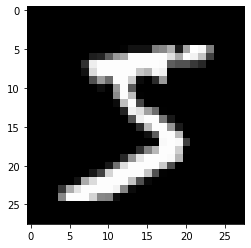

In [148]:
plt.imshow(train_set[0][0][0], cmap='gray');

In [149]:
print(len(train_loader))
print(len(test_loader))

600
100


In [150]:
for i, (images, labels) in enumerate(train_loader):           # checking to see if the data  is in the right format
    print(i, images.size(), len(labels))
    break

0 torch.Size([100, 1, 28, 28]) 100


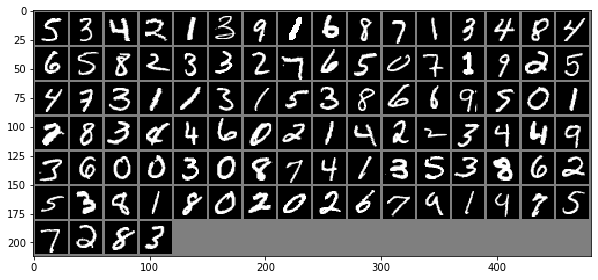

In [151]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

dataiter = iter(train_loader)                               # pulls one batch from the loader
images, labels = dataiter.next()                            # pulls out 64 images for one batch
imshow(torchvision.utils.make_grid(images, nrow=16))
images = images.to(device)
labels = labels.to(device)

In [152]:
#------------------------------------------- Main Neural Network (Fully ReLU) --------------------------------#
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(784, 64)                           # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)                            # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                                     # flattens the tensor
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = self.fc3(X)
        return X
    
    def name(self):
        return "Neural_Network"

In [153]:
model = Neural_Network().to(device)
optimiser = optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [154]:
epochs = 10
history=[]
for epoch in range(epochs):
    train_loss = []  
    model.train()
    for batch in train_loader:                                   #for each batch of images
        X, y = batch
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #X, y = Variable(X), Variable(y)
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model(X) # X.view(-1, 784)
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history.append(loss_now)    
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')

epoch: 0, train loss: 0.476516
epoch: 1, train loss: 0.247309
epoch: 2, train loss: 0.187500
epoch: 3, train loss: 0.156887
epoch: 4, train loss: 0.134902
epoch: 5, train loss: 0.121442
epoch: 6, train loss: 0.109087
epoch: 7, train loss: 0.101153
epoch: 8, train loss: 0.092042
epoch: 9, train loss: 0.085789


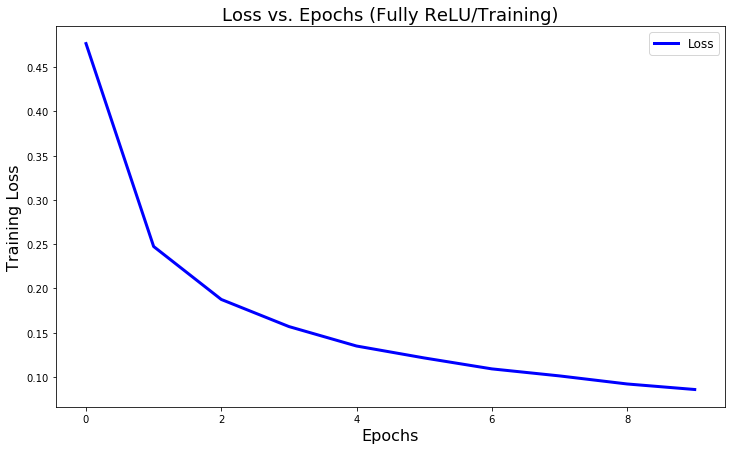

In [155]:
plt.figure(figsize=(12, 7))
plt.plot(history, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (Fully ReLU/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [173]:
pred_list = torch.zeros(0, dtype=torch.long, device='cpu')
label_list = torch.zeros(0, dtype=torch.long, device='cpu')

In [174]:
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)  
        y = y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        pred_list = torch.cat([pred_list, predicted.view(-1).cpu()])
        label_list = torch.cat([label_list, labels.view(-1).cpu()])

RuntimeError: CUDA error: an illegal memory access was encountered

In [171]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 78  74  89  86  65  67  89  85  75  92]
 [115 140 133 145 117  99  94 113  96 148]
 [127 156  89 107 103 116 122 128 122 130]
 [156 184 157 160 151 119 154 172 171 176]
 [110 126 119 105 117 107 105 105 100 106]
 [ 84 103 109 103  97  71  85  81  81  86]
 [ 94 105  73  99  91  75  86  88 100  89]
 [ 93  86  82  82  76  63  68  80  74  96]
 [ 94 103 103  97  87 105  97 110  98 106]
 [ 48  63  53  44  47  47  42  55  52  49]]


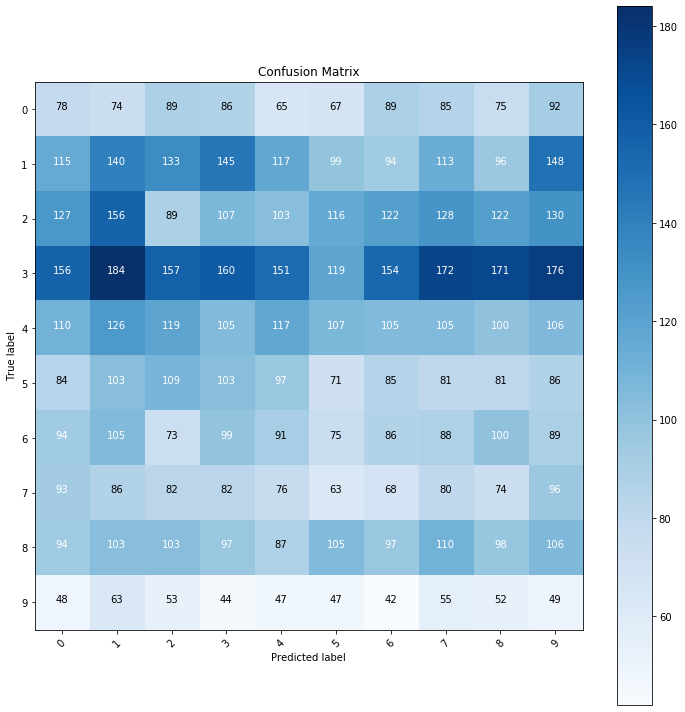

In [172]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cm = confusion_matrix(np.asarray(label_list), np.asarray(pred_list))
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [160]:
class_accuracy = 100*cm.diagonal()/cm.sum(1)
print(class_accuracy)

[ 9.75       11.66666667  7.41666667 10.         10.63636364  7.88888889
  9.55555556 10.          9.8         9.8       ]


In [161]:
print(classification_report(np.asarray(label_list), np.asarray(pred_list), digits=3))

              precision    recall  f1-score   support

           0      0.078     0.098     0.087       800
           1      0.123     0.117     0.120      1200
           2      0.088     0.074     0.081      1200
           3      0.156     0.100     0.122      1600
           4      0.123     0.106     0.114      1100
           5      0.082     0.079     0.080       900
           6      0.091     0.096     0.093       900
           7      0.079     0.100     0.088       800
           8      0.101     0.098     0.100      1000
           9      0.045     0.098     0.062       500

    accuracy                          0.097     10000
   macro avg      0.097     0.097     0.095     10000
weighted avg      0.104     0.097     0.099     10000



In [23]:
#------------------------------------------- Main Neural Network (Fully Sigmoid) --------------------------------#
class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        self.fc1 = nn.Linear(784, 64)                                       # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)                                        # 10 outputs - 0-9
        self.activation = nn.Sigmoid()
        
    def forward(self, X):
        X = X.view(-1, 784)
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = self.fc3(X)
        return X
    
    def name(self):
        return "Neural_Network2"

In [24]:
model2 = Neural_Network2().to(device)
optimiser = optim.Adam(model2.parameters(), lr=0.01, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [25]:
epochs = 10
history=[]
for epoch in range(epochs):  
    avg_loss = 0
    for batch, (X_train, y_train) in enumerate(train_loader):         #for each batch of images
        #------------Moving to device---------#
        X = X_train.to(device)  
        y = y_train.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        X, y = Variable(X), Variable(y)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        #------------Recording results---------#
        avg_loss = avg_loss * 0.9 + loss.data * 0.1
        history.append(avg_loss)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()    
    print(f'epoch: {epoch}, train loss: {avg_loss:.6f}')

epoch: 0, train loss: 0.043629
epoch: 1, train loss: 0.043784
epoch: 2, train loss: 0.034113
epoch: 3, train loss: 0.029738
epoch: 4, train loss: 0.031713
epoch: 5, train loss: 0.021501
epoch: 6, train loss: 0.035202
epoch: 7, train loss: 0.037004
epoch: 8, train loss: 0.040555
epoch: 9, train loss: 0.028099


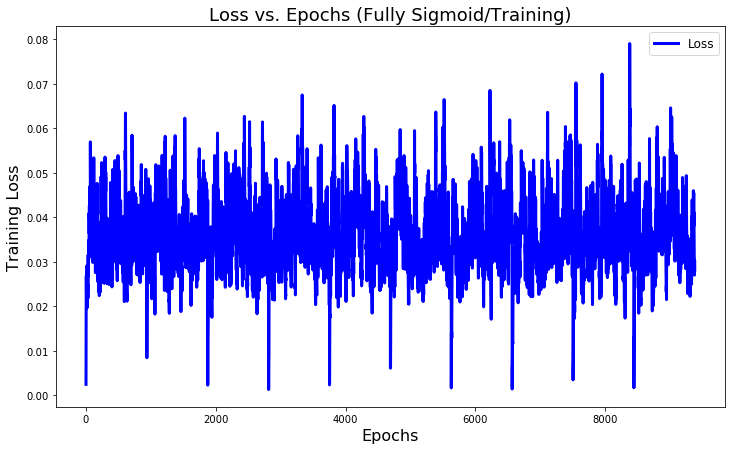

In [28]:
plt.figure(figsize=(12, 7))
plt.plot(history, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (Fully Sigmoid/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [ ]:
#------------------------------------------- Main Neural Network (CNN) --------------------------------#
class Neural_Network3(nn.Module):
    def __init__(self):
        super(Neural_Network3, self).__init__()
        self.fc1 = nn.Linear(784, 64)                                       # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)                                        # 10 outputs - 0-9
        
    def forward(self, X):
        X = X.view(-1, 784)
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = self.fc3(X)
        return X
    
    def name(self):
        return "Neural_Network3"

In [ ]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [ ]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')